<a href="https://colab.research.google.com/github/tomonari-masada/course2023-nlp/blob/main/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

In [3]:
! pip install transformers[torch]
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [4]:
!pip install evaluate

**You may need to restart runtime.**

# Audio classification

In [5]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KWwzcmG98Ds?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Audio classification - just like with text - assigns a class label output from the input data. The only difference is instead of text inputs, you have raw audio waveforms. Some practical applications of audio classification include identifying speaker intent, language classification, and even animal species by their sounds.

This guide will show you how to:

1. Finetune [Wav2Vec2](https://huggingface.co/facebook/wav2vec2-base) on the [MInDS-14](https://huggingface.co/datasets/PolyAI/minds14) dataset to classify speaker intent.
2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[Audio Spectrogram Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/audio-spectrogram-transformer), [Data2VecAudio](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/data2vec-audio), [Hubert](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/hubert), [SEW](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/sew), [SEW-D](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/sew-d), [UniSpeech](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/unispeech), [UniSpeechSat](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/unispeech-sat), [Wav2Vec2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/wav2vec2), [Wav2Vec2-Conformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/wav2vec2-conformer), [WavLM](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/wavlm), [Whisper](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/whisper)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install transformers datasets evaluate
```

We encourage you to login to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to login:

**You need to make a token for write.**

In [26]:
from huggingface_hub import notebook_login

notebook_login()

## Load MInDS-14 dataset

Start by loading the MInDS-14 dataset from the 🤗 Datasets library:

In [7]:
from datasets import load_dataset, Audio

minds = load_dataset("PolyAI/minds14", name="en-US", split="train")

Split the dataset's `train` split into a smaller train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method. This'll give you a chance to experiment and make sure everything works before spending more time on the full dataset.

In [8]:
minds = minds.train_test_split(test_size=0.2)

Then take a look at the dataset:

In [9]:
minds

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})

While the dataset contains a lot of useful information, like `lang_id` and `english_transcription`, you'll focus on the `audio` and `intent_class` in this guide. Remove the other columns with the [remove_columns](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.remove_columns) method:

In [10]:
minds = minds.remove_columns(["path", "transcription", "english_transcription", "lang_id"])

Take a look at an example now:

In [11]:
minds["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~FREEZE/602ba3cc963e11ccd901cc7b.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.        , 0.00024414,
         0.        ]),
  'sampling_rate': 8000},
 'intent_class': 9}

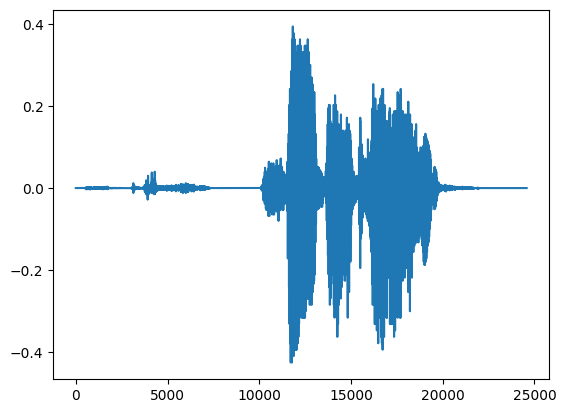

In [12]:
import matplotlib.pyplot as plt

plt.plot(minds["train"][0]['audio']['array']);

There are two fields:

- `audio`: a 1-dimensional `array` of the speech signal that must be called to load and resample the audio file.
- `intent_class`: represents the class id of the speaker's intent.

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:

In [13]:
labels = minds["train"].features["intent_class"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Now you can convert the label id to a label name:

In [14]:
id2label[str(2)]

'app_error'

In [15]:
id2label

{'0': 'abroad',
 '1': 'address',
 '2': 'app_error',
 '3': 'atm_limit',
 '4': 'balance',
 '5': 'business_loan',
 '6': 'card_issues',
 '7': 'cash_deposit',
 '8': 'direct_debit',
 '9': 'freeze',
 '10': 'high_value_payment',
 '11': 'joint_account',
 '12': 'latest_transactions',
 '13': 'pay_bill'}

## Preprocess

The next step is to load a Wav2Vec2 feature extractor to process the audio signal:

In [16]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


The MInDS-14 dataset has a sampling rate of 8000khz (you can find this information in it's [dataset card](https://huggingface.co/datasets/PolyAI/minds14)), which means you'll need to resample the dataset to 16000kHz to use the pretrained Wav2Vec2 model:

In [17]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~FREEZE/602ba3cc963e11ccd901cc7b.wav',
  'array': array([ 2.14992906e-06,  9.01009116e-06, -1.04615174e-06, ...,
          1.80204006e-04,  1.01095011e-05, -6.78790311e-05]),
  'sampling_rate': 16000},
 'intent_class': 9}

In [18]:
minds["train"][0]["audio"]["array"].shape

(49152,)

Now create a preprocessing function that:

1. Calls the `audio` column to load, and if necessary, resample the audio file.
2. Checks if the sampling rate of the audio file matches the sampling rate of the audio data a model was pretrained with. You can find this information in the Wav2Vec2 [model card](https://huggingface.co/facebook/wav2vec2-base).
3. Set a maximum input length to batch longer inputs without truncating them.

In [19]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) function. You can speed up `map` by setting `batched=True` to process multiple elements of the dataset at once. Remove the columns you don't need, and rename `intent_class` to `label` because that's the name the model expects:

In [20]:
encoded_minds = minds.map(preprocess_function, remove_columns="audio", batched=True)
encoded_minds = encoded_minds.rename_column("intent_class", "label")

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load a evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [21]:
import evaluate

accuracy = evaluate.load("accuracy")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [22]:
import numpy as np

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

Your `compute_metrics` function is ready to go now, and you'll return to it when you setup your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load Wav2Vec2 with [AutoModelForAudioClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForAudioClassification) along with the number of expected labels, and the label mappings:

In [23]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.bias', 'classifier.bias', 'classifier.weight', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [27]:
training_args = TrainingArguments(
    output_dir="my_awesome_mind_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,2.640886,0.017699
1,No log,2.644352,0.061947
2,2.634400,2.646049,0.061947
4,2.634400,2.652157,0.044248
4,2.634400,2.654073,0.035398
5,2.627700,2.653331,0.061947
6,2.627700,2.652805,0.061947
8,2.616000,2.653765,0.061947


TrainOutput(global_step=30, training_loss=2.626022211710612, metrics={'train_runtime': 172.3903, 'train_samples_per_second': 26.104, 'train_steps_per_second': 0.174, 'total_flos': 3.26841433344e+16, 'train_loss': 2.626022211710612, 'epoch': 8.0})

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [28]:
trainer.push_to_hub()

'https://huggingface.co/tmasada/my_awesome_mind_model/tree/main/'

<Tip>

For a more in-depth example of how to finetune a model for audio classification, take a look at the corresponding [PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/audio_classification.ipynb).

</Tip>

## Inference

Great, now that you've finetuned a model, you can use it for inference!

Load an audio file you'd like to run inference on. Remember to resample the sampling rate of the audio file to match the sampling rate of the model if you need to!

In [29]:
from datasets import load_dataset, Audio

dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["path"]

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for audio classification with your model, and pass your audio file to it:

In [30]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="stevhliu/my_awesome_minds_model")
classifier(audio_file)

[{'score': 0.09766869246959686, 'label': 'cash_deposit'},
 {'score': 0.07998877018690109, 'label': 'app_error'},
 {'score': 0.0781070664525032, 'label': 'joint_account'},
 {'score': 0.07667109370231628, 'label': 'pay_bill'},
 {'score': 0.0755252093076706, 'label': 'balance'}]

You can also manually replicate the results of the `pipeline` if you'd like:

Load a feature extractor to preprocess the audio file and return the `input` as PyTorch tensors:

In [31]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("stevhliu/my_awesome_minds_model")
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

Pass your inputs to the model and return the logits:

In [33]:
import torch
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained("stevhliu/my_awesome_minds_model")
with torch.no_grad():
    logits = model(**inputs).logits

Get the class with the highest probability, and use the model's `id2label` mapping to convert it to a label:

In [34]:
predicted_class_ids = torch.argmax(logits).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'cash_deposit'